In [24]:
import os
import zipfile
import tempfile
import numpy as np
import pydicom
from glob import glob
import pandas as pd
from skimage.transform import resize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def process_zip_file(zip_file, temp_dir, save_dir):
    """
    Process a single MRI .zip file, extract DICOM slices, and save as .npy file.

    Args:
        zip_file (str): Path to the .zip file.
        temp_dir (str): Temporary directory to unzip files.
        save_dir (str): Directory to save .npy files.
    """
    try:
        # Extract patient ID and visit number from the .zip file name
        base_name = os.path.basename(zip_file).replace(".zip", "")
        parts = base_name.split("_")
        patient_id = parts[0]
        visit_number = parts[2]

        # Define the output .npy file name
        output_file = os.path.join(save_dir, f"{patient_id}_{visit_number}.npy")

        # Skip if the .npy file already exists
        if os.path.exists(output_file):
            return

        # Unzip the file into the temporary directory
        with tempfile.TemporaryDirectory(dir=temp_dir) as temp_unzip_dir:
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(temp_unzip_dir)

            # Load the manifest file
            manifest_path = os.path.join(temp_unzip_dir, "manifest.cvs")
            if not os.path.exists(manifest_path):
                return

            # Find DICOM files in the extracted folder
            dicom_files = glob(os.path.join(temp_unzip_dir, "**/*.dcm"), recursive=True)

            if not dicom_files:
                return

            def process_dicom_file(dicom_path):
                try:
                    dicom_data = pydicom.dcmread(dicom_path, stop_before_pixels=False)
                    pixel_array = dicom_data.pixel_array
                    resized_array = resize(pixel_array, (224, 224), mode='reflect', anti_aliasing=True)
                    # Return the resized image along with the Instance Number for sorting
                    instance_number = getattr(dicom_data, "InstanceNumber", None)
                    return instance_number, resized_array
                except Exception:
                    return None

            # Process all DICOM files
            processed_slices = [
                process_dicom_file(dicom) for dicom in dicom_files if process_dicom_file(dicom) is not None
            ]

            # Filter out failed reads and sort by Instance Number
            processed_slices = [slice_ for slice_ in processed_slices if slice_ is not None]
            processed_slices.sort(key=lambda x: x[0])  # Sort by Instance Number

            # Extract the resized slices in sorted order
            slices = [slice_[1] for slice_ in processed_slices]

            if not slices:
                return

            # Stack slices into a 3D array
            volume = np.stack(slices, axis=0)

            # Save the volume as a .npy file
            np.save(output_file, volume)
    except Exception as e:
        print(f"Error processing file {zip_file}: {e}")

def process_all_mri_zips(zip_dir, temp_dir, save_dir):
    """
    Process all MRI .zip files in a directory concurrently, extract DICOM slices, and save as .npy files.

    Args:
        zip_dir (str): Directory containing .zip files.
        temp_dir (str): Temporary directory to unzip files.
        save_dir (str): Directory to save .npy files.
    """
    os.makedirs(temp_dir, exist_ok=True)
    os.makedirs(save_dir, exist_ok=True)

    zip_files = glob(os.path.join(zip_dir, "*.zip"))

    with ThreadPoolExecutor() as executor:
        list(tqdm(executor.map(lambda z: process_zip_file(z, temp_dir, save_dir), zip_files), total=len(zip_files), desc="Processing MRI Zips"))

# Example usage
zip_directory = "/corral/utexas/UKB-Imaging-Genetics/temp_imaging_data/FID20210_aortic_distensibilty"
temp_unzip_directory = "../FID20210/temp_unzip"
save_directory = "../FID20210_Images"

process_all_mri_zips(zip_directory, temp_unzip_directory, save_directory)

Processing MRI Zips: 100%|██████████| 71987/71987 [13:21:35<00:00,  1.50it/s]   


In [12]:
import numpy as np

# Path to the .npy file
npy_file_path = "../FID20210_Images/1000026_2.npy"

# Load the .npy file
volume = np.load(npy_file_path)

# Print the shape of the loaded array
print(f"The shape of the loaded volume is: {volume.shape}")

The shape of the loaded volume is: (100, 224, 224)


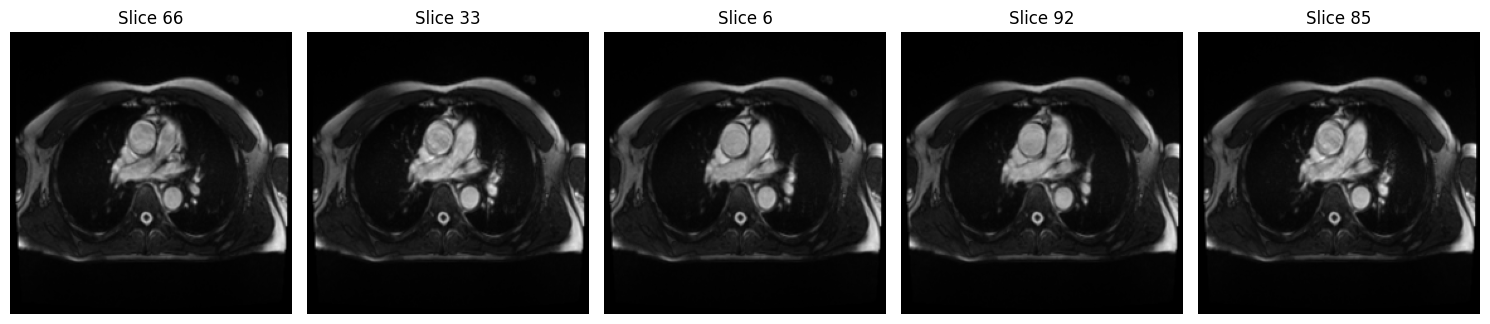

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

def show_random_slices(npy_file, num_slices=5):
    """
    Load a .npy file and display random slices from it.

    Args:
        npy_file (str): Path to the .npy file.
        num_slices (int): Number of random slices to display.
    """
    # Load the .npy file
    volume = np.load(npy_file)

    # Check the total number of slices
    total_slices = volume.shape[0]

    # Randomly select slices
    random_indices = random.sample(range(total_slices), min(num_slices, total_slices))

    # Plot the slices
    plt.figure(figsize=(15, 5))
    for i, index in enumerate(random_indices):
        plt.subplot(1, len(random_indices), i + 1)
        plt.imshow(volume[index], cmap='gray')
        plt.title(f"Slice {index}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
npy_file_path = "../FID20210_Images/1000026_2.npy"
show_random_slices(npy_file_path)